**RTSA 2023**

# Project B: LTE Line Formation

This project is based on Robert J. Rutten's "Stellar Spectra B" exercises.

#### Header and imports

The cells below contain some recommended python imports to solve the exercises.

In [1]:
%matplotlib inline
# Only if you have a high-resolution "retina" display:
%config InlineBackend.figure_format = 'retina'

import numpy
import matplotlib.pyplot as plt
from astropy import units
from astropy import constants
from astropy.table import QTable  # to use tables with units
from astropy.visualization import quantity_support

quantity_support()
plt.rc('legend', frameon=False)
plt.rc('figure', figsize=(7, 7 / 1.75)) # Larger figure sizes
plt.rc('font', size=12)

## 1. Background

In this project you will go beyond simple models of radiation in stars and use more realistic models of a stellar atmosphere, for the particular case of the Sun. The exercises will build on the different ingredients to achieve the final goal: to calculate the predicted spectral lines from a model atmosphere of a star. This is a fundamental task to study any star in detail, and is a building block of most of what we know about stars.



### 1.1 A 1D Model for the Solar Atmosphere: FALC

You will use the standard one-dimensional (1D) FALC model by 
[Fontenla et al. (1993)](http://adsabs.harvard.edu/abs/1993ApJ...406..319F).
The authors derived this model semi-empirically, assuming that the solar atmosphere is horizontally homogeneous ("plane parallel layers") and in hydrostatic equilibrium ("time independent"). This model was not derived from first-principle physics, but by a combination of physics and empirical adjustments (so called semi-empirical model), so that its properties match the observations of the Sun (as much as possible). 

<img src="https://tiagopereira.space/ast4310/images/avrett_pic.svg" width=250px>

*Eugene H. Avrett (born 1933)
    represents the A in the VAL (Vernazza, Avrett and Loeser) and FAL
    (Fontenla, Avrett and Loeser) sequences of standard models of the
    solar atmosphere.
    At the Center for Astrophysics (Cambridge, Mass.) he developed,
    together with programmer Rudolf Loeser, an enormous spectrum
    modeling code (called Pandora, perhaps a fitting name) which fits
    observed solar continua and lines throughout the spectrum through
    the combination of trial-and-error adjustment of the temperature
    stratification with simultaneous evaluation of the corresponding
    particle densities with great sophistication, basically performing
    complete NLTE population analysis for all key transitions in the
    solar spectrum.
    His [VALIII paper](http://adsabs.harvard.edu/abs/1981ApJS...45..635V) stands as one of the three prime solar physics
    papers of the second half of the twentieth century (with [Parker's solar wind](http://adsabs.harvard.edu/abs/1958ApJ...128..664P) prediction and [Ulrich's p-mode](http://adsabs.harvard.edu/abs/1970ApJ...162..993U) prediction).
    Photograph from the web.*


The FALC model is given here in the `falc.dat` file. We can load the file into a useful `astropy.table.QTable` object with the correct units using the metadata in the file:

In [2]:
def read_table_units(filename):
    """
    Reads a table in a text file, formatted with column names in first row,
    and unit names on second row. Any deviation from this format will fail.
    """
    tmp = numpy.genfromtxt(filename, names=True)
    unit_names = open(filename).readlines()[1][1:].split()
    # Convert to astropy QTable to have units
    data = QTable(tmp)
    # Assign units to quantities in table, use SI units
    for key, unit in zip(data.keys(), unit_names):
        data[key].unit = unit
        data[key] = data[key].si  # We don't want to use deprecated units
    return data

In [3]:
falc = read_table_units("falc.dat")
falc

height,tau_500,colmass,temperature,v_turb,hydrogen_density,proton_density,electron_density,pressure,p_ratio,density
m,,kg / m2,K,m / s,1 / m3,1 / m3,1 / m3,N / m2,,kg / m3
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2218200.0,0.0,6.777e-05,100000.0,11730.0,5574999999999999.0,5574999999999999.0,6664999999999999.0,0.01857,0.952,1.3059999999999998e-11
2216500.0,7.696e-10,6.779e-05,95600.0,11650.0,5837999999999999.0,5836999999999999.0,6946999999999999.0,0.01857,0.95,1.3679999999999998e-11
2214890.0,1.531e-09,6.781e-05,90816.0,11560.0,6150999999999999.0,6149999999999999.0,7283999999999999.0,0.01858,0.948,1.4409999999999997e-11
2212770.0,2.597e-09,6.785e-05,83891.0,11420.0,6667999999999999.0,6666999999999999.0,7833999999999999.0,0.018590000000000002,0.945,1.562e-11
2210640.0,3.754e-09,6.788000000000001e-05,75934.0,11250.0,7380999999999999.0,7377999999999999.0,8575999999999999.0,0.018600000000000002,0.941,1.729e-11
2209570.0,4.384e-09,6.79e-05,71336.0,11140.0,7863999999999999.0,7857999999999999.0,9075999999999998.0,0.018600000000000002,0.938,1.8429999999999998e-11
...,...,...,...,...,...,...,...,...,...,...
-40000.0,2.946,55.67,7590.0,1730.0,1.2799999999999998e+23,4.2489999999999993e+20,4.4799999999999993e+20,15250.0,0.971,0.0003


The first column specifies the height $h$
which is the distance above $\tau_{500}$ =1 where
$\tau_{500}$, given in the second column, 
is the radial optical depth in the continuum at 
$\lambda$ = 500 nm. The quantity `colmass` in the third column is the 
mass of a column with cross-section of 1 m$^2$ above the given
location.  

In the photosphere ($-$100 $\leq h\leq$ 525 km) and chromosphere (525 $\leq h\leq$ 2100 km) the temperature $T$ (fourth column) has been
adjusted empirically so that the computed spectrum is in agreement
with the spatially averaged disk-centre spectrum observed from quiet 
solar areas (away from active regions). The temperature distribution
in the transition region (above $h\approx$ 2100 km, up to $T$ = 10$^5$ K) has been determined theoretically by balancing the downflow of energy from the corona through thermal conduction and diffusion against the radiative energy losses.

The microturbulence or turbulent velocity `v_turb` is a "fudge factor" to compensate for the lack of Doppler broadening in a 1D model. It has been adjusted at each height to accounts for the observed Doppler broadening of lines formed at various heights. It can compensate for the width of the lines, but cannot describe the observed line asymmetries that arise from velocities at different heights.


The table also lists the total hydrogen density $n_{\rm H}$ (`hydrogen_density`, which includes both neutral hydrogen and protons), the
free proton density $n_{\rm p}$ (`proton_density`), the free electron density $n_{\rm e}$ (`electron_density`), and a few other quantities. 

Each quantity in the `QTable` can be accessed by its label, e.g. `falc['temperature']`. Here is a plot of the FALC temperature stratification in the range of temperatures where most of the radiation escapes:

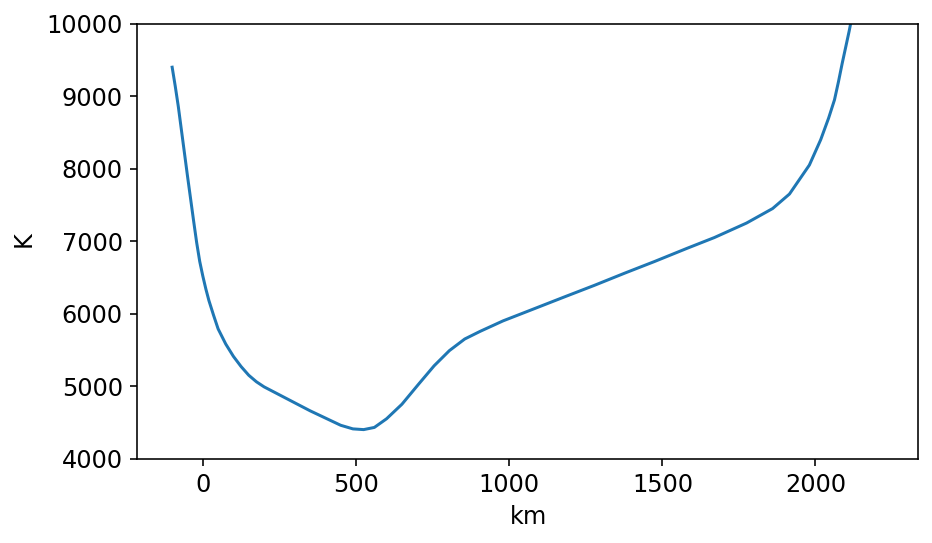

In [4]:
fig, ax = plt.subplots()
ax.plot(falc['height'].to('km'), falc['temperature'])
ax.set_ylim(4000, 10000);

Because this is a 1D static model, it is meant to reproduce the time- and space-averaged atmosphere of the Sun. Many people take this model as a true representation of the average Sun. This is wrong. It is at best a "spectroscopically-equivalent" model of the average Sun, meaning that the radiation and spectral lines computed from this model match the time and space-averaged spectral lines observed on the Sun. The temporal and spatial inhomogeneities in the surface of the Sun mean that no 1D cut through the atmosphere is reproduced by the FALC model. To accurately describe the complex solar atmosphere, a 3D model is needed.

### 1.2 A 3D Model for the Solar Atmosphere

 <img src="https://i1.rgstatic.net/ii/profile.image/272391284719621-1441954551201_Q512/Robert_Stein.jpg" width="250px" alt="Bob Stein"> <img src="https://www.astro.ku.dk/~aake/aa03-med.jpg" style="width=250px; margin: -75px;" alt="Åke Nordlund">

*[Bob Stein](https://web.pa.msu.edu/people/steinr/research.html) (left, born 1935) and [Åke Nordlund](https://www.astro.ku.dk/~aake/)</a> (right, born 1947) are two pioneers of computer simulations of magneto-hydrodynamics (MHD). Their study of plasma constrained by magnetic fields have had a deep impact in various fields, from planetary formation to the very finest scales in stellar surfaces. In particular, their prolific work on convection in the atmospheres of cool stars has led to a paradigm shift from seeing stellar atmospheres as static 1D plane-parallel objects to highly-dynamic 3D atmospheres. Their seminal work [Simulations of Solar Granulation](https://ui.adsabs.harvard.edu/abs/1998ApJ...499..914S) triggered a new age in the study of the solar and stellar atmospheres, where spectral calculations from 3D MHD simulations of convection became feasible and challenged our understanding of stellar spectra. Using such simulations, the solar metallicity,  stable during decades of modelling and observations, was suddenly challenged and revised by almost half by [Asplund et al. (2005)](https://ui.adsabs.harvard.edu/abs/2005ASPC..336...25A). The codes developed by Nordlund and Stein have thrived and continued to be developed and updated at many research groups. They were at the origin of the Bifrost code, actively developed at the University of Oslo and the source for the simulation in this Project. Photographs from the web.*

The 1D FALC model is horizontally homogeneous ("plane parallel layers") and in hydrostatic equilibrium ("time independent"). Of course, the solar atmosphere is neither homogeneous nor static. A more realistic description of a stellar atmosphere is given by time-dependent, radiative 3D magneto-hydrodynamic (MHD) simulations. They can capture more physics, such as a realistic treatment of convection and radiation at different depths, and don't need the fudge factors such as microturbulence to make the spectra look like the observations. 

A proper use of 3D models should include the temporal dimension, but for the sake of convenience and speedy calculations, we will use only a single timestep in this exercise. 

The 3D simulation file is too large to host on Github, so you need to [download it](https://www.uio.no/studier/emner/matnat/astro/AST4310/h20/data/qs006024_sap_s285.fits) (132 MB) and save it to the current directory. This is one timestep of a simulation run with the [Bifrost code](https://ui.adsabs.harvard.edu/abs/2011A%26A...531A.154G/abstract). This particular simulation is of quiet Sun (no strong magnetic fields), covers only a relatively small region (6 Mm x 6 Mm horizontal size), and does not include the hotter layers of the transition region and corona (not relevant for this exercise). Here it is saved as a `QTable` in a special type of FITS file, so we can read it by:

In [5]:
# Make sure the path points to the file in your computer
DATA_FILE = "qs006024_sap_s285.fits"
atm3d = QTable.read(DATA_FILE)
atm3d

temperature,electron_density,hydrogen_density,velocity_z,height,velocity_y,velocity_x,pressure
K,1 / m3,1 / m3,m / s,m,m / s,m / s,Pa
"float32[256,256]","float32[256,256]","float32[256,256]","float32[256,256]",float64,"float32[256,256]","float32[256,256]","float32[256,256]"
5272.96923828125 .. 5284.5224609375,4.0828113734598656e+17 .. 4.22937661703979e+17,1.1546960635975193e+21 .. 1.1705831446017663e+21,157.57679748535156 .. 188.99781799316406,583024.0,-591.6886596679688 .. -594.4967041015625,151.15953063964844 .. 138.1940155029297,92.58880615234375 .. 94.07086181640625
5403.09130859375 .. 5411.1669921875,5.892596861260268e+17 .. 6.056246110354145e+17,1.268329059807983e+21 .. 1.2855685577065806e+21,279.1968994140625 .. 312.5419616699219,570330.6,-607.3775634765625 .. -610.0527954101562,148.22718811035156 .. 134.47979736328125,104.22808837890625 .. 105.80181884765625
5457.4619140625 .. 5460.5078125,7.130042222740767e+17 .. 7.238788733091185e+17,1.4060311220144633e+21 .. 1.4257131190234676e+21,397.9075622558594 .. 431.21435546875,557637.2000000001,-673.2451171875 .. -675.8231811523438,133.34869384765625 .. 116.03425598144531,116.7034912109375 .. 118.40267181396484
5481.47607421875 .. 5478.60009765625,8.02345177027969e+17 .. 8.032026586586808e+17,1.5645948428573422e+21 .. 1.5871253666306583e+21,493.31866455078125 .. 525.1014404296875,544943.7999999999,-847.243896484375 .. -849.96142578125,92.8567886352539 .. 66.19844055175781,130.43585205078125 .. 132.2436981201172
5437.236328125 .. 5425.58447265625,7.704930810855424e+17 .. 7.55770551670145e+17,1.7582095166500923e+21 .. 1.7849445728880238e+21,576.6238403320312 .. 605.1107177734375,532250.4,-1198.0218505859375 .. -1198.6129150390625,34.679115295410156 .. -6.235204219818115,145.38577270507812 .. 147.28074645996094
5307.6630859375 .. 5274.84521484375,6.150925743816704e+17 .. 5.789578806490563e+17,2.0056081475177378e+21 .. 2.0432271374176286e+21,639.0731811523438 .. 667.4573364257812,519557.00000000006,-1625.5244140625 .. -1612.75390625,-4.219546318054199 .. -54.43379211425781,161.87940979003906 .. 163.8760986328125
...,...,...,...,...,...,...,...
11589.94921875 .. 11593.806640625,2.6216174006864036e+22 .. 2.6315467119648488e+22,2.038237317915488e+23 .. 2.0436311891171972e+23,2663.761962890625 .. 2643.78955078125,-302254.7,361.02813720703125 .. 359.9884338378906,728.10498046875 .. 742.7396850585938,40124.42578125 .. 40248.75


The file structure was built so that it looks very similar to the loaded FALC model. Many of the variable names have the same names (e.g. `temperature`, `electron_density`), but not all the quantities present in the FALC model are here. `vturb` is absent, but instead we have `velocity_z`, `velocity_y`, and `velocity_x`, respectively the velocity components in the z, y, and x axes. You will also notice that each variable is now a 3D array, e.g.:

In [6]:
atm3d['temperature'].shape

(75, 256, 256)

The array dimensions are (nz = 75, ny = 256, nx = 256). We can compare some quantities between the FALC and one column of the 3D model:

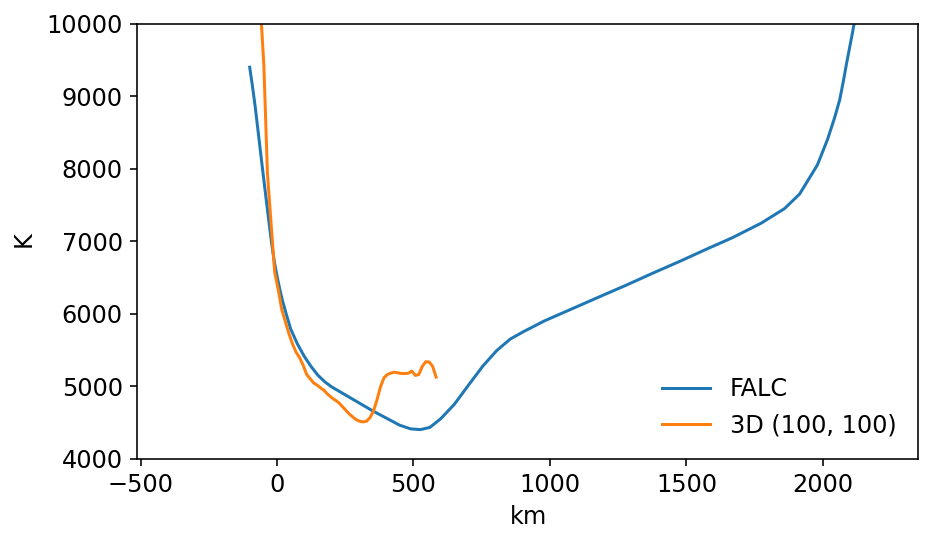

In [7]:
fig, ax = plt.subplots()
ax.plot(falc['height'].to('km'), falc['temperature'], label='FALC')
# show column (100, 100):
ax.plot(atm3d['height'].to('km'), atm3d['temperature'][:, 100, 100], label='3D (100, 100)')
ax.set_ylim(4000, 10000)
ax.legend();

We can also visualise the horizontal maps of variables at a given height using matplotlib's `imshow` function. Here for the temperature at the bottom of the atmosphere (last height point):

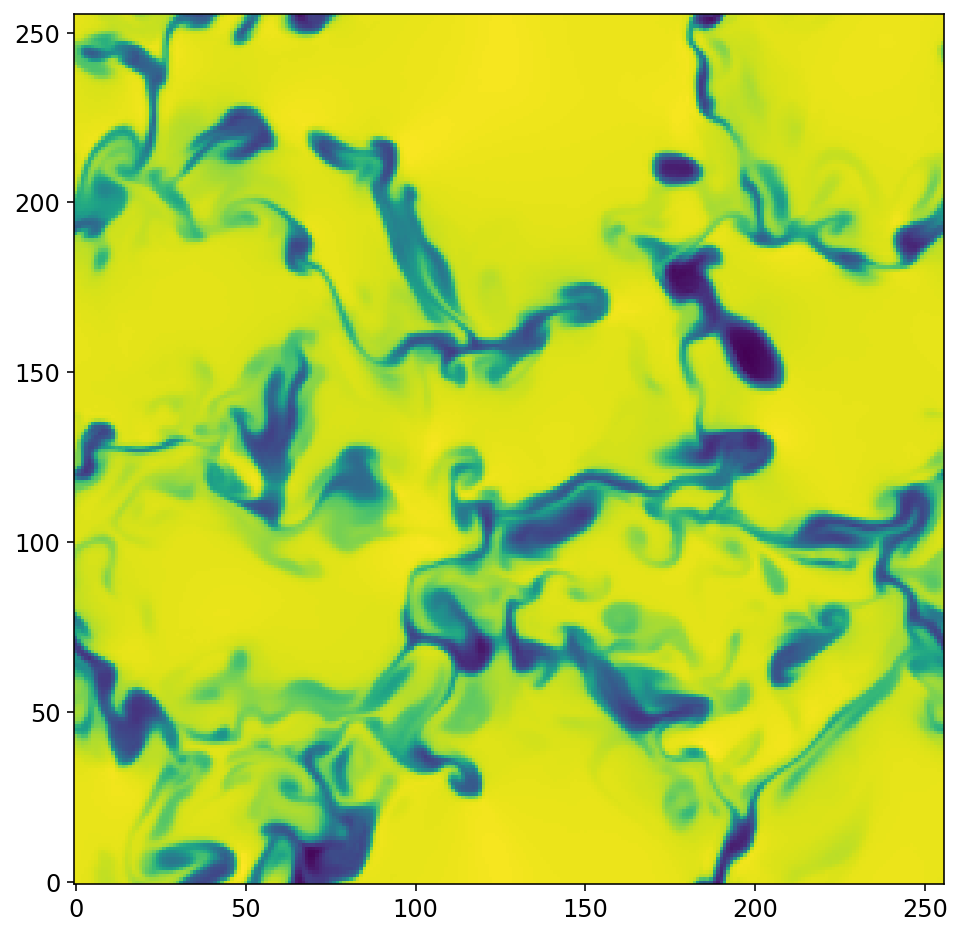

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(atm3d['temperature'][-1]);

### 1.3 Continuous Spectrum from the Solar Atmosphere

We now turn to the formation of the solar continuum radiation,
concentrating on the visible and near-infrared parts of its spectrum.

<img src="https://tiagopereira.space/ast4310/images/Subrahmanyan_Chandrasekhar.gif" width=200px>

*Subrahmanyan Chandrasekhar (1910-1995) is regarded by many as the greatest astronomer of the twentieth century. He also played an important role in the topic of this exercise, undertaking a very lengthy and difficult calculation (not a computation, no computers yet at that time!) of the bound-free and free-free extinction cross-sections of the H$^-$ ion, together with F.H. Breen. Their result, published in [Chandrasekhar & Breen (1946)](http://adsabs.harvard.edu/abs/1946ApJ...104..430C) will be duplicated in one of your graphs below. The shape of the extinction curve, 
with a peak near $\lambda$ = 1 μm and a minimum at the H$^-$ bound-free ionisation limit at $\lambda$ = 1.6 μm , reproduced the observed spectral variation of the unknown solar continuum extinction as derived already by G.F.W. Mulders at Utrecht in 1935 for $\lambda$ = 0.4- 2.5 μm. The brilliant suggestion that H$^-$ might cause this extinction, instead of the ensemble of unknown metal edges that was earlier postulated, had already been given by [Pannekoek (1930)](http://adsabs.harvard.edu/abs/1930MNRAS..91..139P), but was forgotten until it came independently from [Wildt (1939)](http://adsabs.harvard.edu/abs/1939ApJ....89..295W). The proof came with Chandrasekhar's laborious quantum mechanical evaluation and explained how the solar atmosphere can be opaque at gas densities much lower than the transparent air around us, as you found in the previous exercise. It revolutionised the understanding of cool-star atmospheres by much increasing their hydrogen-to-metals ratio and gas pressure compared with the earlier metallic-absorption modeling of Biermann, Uns&ouml;ld and Pannekoek himself. A more detailed description is found in [Hearnshaw (1986)](http://adsabs.harvard.edu/abs/1986asoh.book.....H). Photograph from Wikimedia commons.*


#### 1.3.1 Continuous Extinction


<img src="https://tiagopereira.space/ast4310/images/gray8-6a.svg" width=700px>

*Continuous extinction coefficients $\kappa_\nu^c$ for hydrogen and helium, per neutral hydrogen atom and per unit electron pressure, for the depth $\tau_0$ = 1 (continuum optical depth at $\lambda$ = 500 nm) in the photosphere of a solar-like dwarf star. The coefficients $\kappa$ are here measured per neutral hydrogen atom in whatever state of excitation, assuming Saha-Boltzmann population partitioning, and normalised by the electron pressure $P_\mathrm{e} = n_\mathrm{e} k \, T$. The cross-sections are in units of 10$^{-26}$cm$^2$ (not cm$^2$ as specified in the $y$-axis label); stimulated emission was not included in the computation of these curves. The H$^-$ curve shows the bound-free Balmer, Paschen and Brackett edges, plus part of the Pfund edge at right. The curves do not extend beyond the Balmer edge at left where the neglected metal edges become important. Thomson scattering is also neglected. From page 140 of [Gray (1992)](http://adsabs.harvard.edu/abs/1992oasp.book.....G).*

<img src="https://tiagopereira.space/ast4310/images/krijger-ion2.svg" width=400px>

*Ionisation edges for a selection of abundant elements. The triangular symbols depict bound-free continuum edges in the form of schematic hydrogenic $\nu^{-3}$ decay functions above each ionisation threshold. The plot shows the edge distribution over ionisation energy $\chi_{1c}$ (along the bottom) or threshold wavelength (along the top) and the logarithmic product of the element abundance $A_{12} \equiv \log (n_{\rm E}/n_{\rm H} +12)$ and the bound-free cross-section per particle at threshold $\sigma/\sigma_{\rm H}$ (vertically). Thus, it shows the relative importance of the major bound-free edges throughout the spectrum. They are all at ultraviolet wavelengths and do not contribute extinction in the visible and infrared. The plus signs indicate important first-ion edges; higher ionisation stages produce edges at yet shorter wavelengths. The abundance values come from [Engvold (1977)](http://adsabs.harvard.edu/abs/1977PhyS...16...48E), abundances the ionisation energies from [Novotny (1973)](http://adsabs.harvard.edu/abs/1973itsa.book.....N), the cross-sections from the chapter by [Baschek and Scholtz (1982)](http://adsabs.harvard.edu/abs/1982lbg6.conf.....A) This Krijger production following unpublished lecture notes by E.H. Avrett, taken from the [RTSA lecture notes](http://www.staff.science.uu.nl/~rutte101/Course_notes.html).*

We will assume that H$^-$(a hydrogen atom with an extra electron) is the major provider of continuous extinction in the solar atmosphere.  This is quite a good assumption
for the solar photosphere for wavelengths $\lambda$ > 0.5 μm. The second-best extinction provider are H I bound-free interactions, at only a few percent.  This may be seen in Figure above, taken from [Gray (1992)](http://adsabs.harvard.edu/abs/1992oasp.book.....G).

Below $\lambda$ = 500 nm there is heavy line crowding (not added in the figure from Gray) which acts as a quasi-continuum.  Below $\lambda$ = 365 nm the Balmer bound-free edge provides large extinction, and at yet shorter wavelengths the bound-free ionisaton edges of various metals (Al I, Mg I, Fe I, Si I, C I) provide steep extinction increase yet before the H I Lyman continuum sets in, as may be expected from the ionisation edges figure. In this exercise we will neglect these contributions by evaluating only the H$^-$ extinction and the extinction due to scattering off free electrons (Thomson scattering).

To calculate the H$^-$ continuous extinction we will use different tabulated values for the cross section of the H$^-$ bound-free and free-free contribution. For bound-free we use a table based on [Wishart (1979)](https://ui.adsabs.harvard.edu/abs/1979MNRAS.187P..59W) and [Broad and Reinhardt (1976)](https://ui.adsabs.harvard.edu/abs/1976PhRvA..14.2159B) (often referred to as WBR), coded in the function `cross_section_hminus_bf()` below. This function returns the cross section per H$^-$ ion. To obtain the linear extinction $\alpha_\lambda$, you need to multiply it by the number density of H$^-$ atoms (units of m$^{-3}$), which you can obtain from the number density of neutral hydrogen atoms using the Saha distribution (use $\chi$=0.754 eV for the H$^-$ binding energy, the partition function U(H$^{-1}$)=1). For the free-free contribution we will use the recipe from [John (1988)](https://ui.adsabs.harvard.edu/abs/1988A%26A...193..189J/abstract), coded in the function `cross_section_hminus_ff()`. This function returns the "cross section coefficient" (units of m$^5$) per hydrogen atom per electron. To obtain the linear extinction you need to multiply it by the number density of neutral hydrogen atoms and the electron density. The H$^-$ total extinction is the sum of the bound-free and free-free parts.

In [5]:
def cross_section_hminus_bf(wavelength, temperature):
    """
    Gets the H^- bound-free cross section using the recipes of
    Wishart (1979) and Broad and Reinhardt (1976).
    
    Parameters
    ----------
    wavelength : astropy.units.quantity (scalar or array)
        Wavelength to calculate in units of length.
    temperature: astropy.units.quantity (scalar or array)
        Gas temperature in units of K or equivalent.
        
    Returns
    -------
    cross_section : astropy.units.quantity (scalar or array)
        cross section (in m^2) per H^- ion.
    """
    wbr_λ = numpy.array(
        [  18, 19.6, 21.4, 23.6, 26.4, 29.8, 34.3, 40.4, 49.1, 62.6,  121, 139,
          164,  175,  200,  225,  250,  275,  300,  325,  350,  375,  400, 425,
          450,  475,  500,  525,  550,  575,  600,  625,  650,  675,  700, 725,
          750,  775,  800,  825,  850,  875,  900,  925,  950,  975, 1000, 1025,
         1050, 1075, 1100, 1125, 1150, 1175, 1200, 1225, 1250, 1275, 1300, 1325,
         1350, 1375, 1400, 1425, 1450, 1475, 1500, 1525, 1550, 1575, 1600, 1610,
         1620, 1630]
    ) * units.nm  # in nm
    wbr_σ = numpy.array(
        [0.067, 0.088, 0.117, 0.155, 0.206, 0.283, 0.414, 0.703,  1.24,  2.33,
          5.43,  5.91,  7.29, 7.918, 9.453, 11.08, 12.75, 14.46, 16.19, 17.92,
         19.65, 21.35, 23.02, 24.65, 26.24, 27.77, 29.23, 30.62, 31.94, 33.17,
         34.32, 35.37, 36.32, 37.17, 37.91, 38.54, 39.07, 39.48, 39.77, 39.95,
         40.01, 39.95, 39.77, 39.48, 39.06, 38.53, 37.89, 37.13, 36.25, 35.28,
         34.19, 33.01, 31.72, 30.34, 28.87, 27.33, 25.71, 24.02, 22.26, 20.46,
         18.62, 16.74, 14.85, 12.95, 11.07, 9.211, 7.407, 5.677, 4.052, 2.575,
         1.302, 0.8697, 0.4974, 0.1989]
    ) * 1e-22 * units.m**2
    sigma = numpy.interp(wavelength, wbr_λ, wbr_σ)
    # correct for stimulated emission
    sigma = sigma *  (1 - numpy.exp(-constants.h * constants.c /
                                    (wavelength * constants.k_B * temperature)))
    return sigma
    

def cross_section_hminus_ff(wavelength, temperature):
    """
    Gets the H^- free-free cross section coefficient using the recipe
    of John (1988). Includes stimulated emission.
    
    Parameters
    ----------
    wavelength : astropy.units.quantity (scalar)
        Wavelength to calculate in units of length.
    temperature: astropy.units.quantity (scalar or array)
        Gas temperature in units of K or equivalent.
        
    Returns
    -------
    cross_section : astropy.units.quantity (scalar or array)
        H^- ff cross section coefficient (in m^5) per neutral hydrogen atom per electron.
    """
    table = numpy.array([
        [    0.0000,     0.0000,      0.0000,      0.0000,     0.0000,    0.0000],
        [ 2483.3460,   285.8270,  -2054.2910,   2827.7760, -1341.5370,  208.9520],
        [-3449.8890, -1158.3820,   8746.5230, -11485.6320,  5303.6090, -812.9390],
        [ 2200.0400,  2427.7190, -13651.1050,  16755.5240, -7510.4940, 1132.7380],
        [ -696.2710, -1841.4000,   8624.9700, -10051.5300,  4400.0670, -655.0200],
        [   88.2830,   444.5170,  -1863.8640,   2095.2880,  -901.7880,  132.9850]]
    ) 
    sqrtθ = numpy.sqrt(5040 / temperature.to_value("K"))
    wave_mu = wavelength.to_value("um")
    wave_inv = 1. / wave_mu
    kappa = 0.
    for i in range(6):
        kappa += sqrtθ**(i + 2) * (wave_mu**2 * table[i, 0] + table[i, 1] +
                       wave_inv * (table[i, 2] + wave_inv * (table[i, 3] +
                       wave_inv * (table[i, 4] + wave_inv * table[i, 5]))))
    kappa = kappa * 1e-32 * units.m**4 / units.N  # Put units from table
    return (kappa * constants.k_B * temperature).to("m^5")  

To calculate the number density of neutral hydrogen in the 3D case, we need to use the Saha equation. In the FALC model, the proton density is given, so we can just subtract it from `hydrogen_density` to obtain the neutral hydrogen density. The H$^-$ number density must be calculated from the neutral hydrogen density using the Saha equation, with the H$^-$ dissociation energy of about 0.12 aJ. Here are some helpful functions to do this:

In [5]:
def compute_h_neutral_frac(temperature, electron_density):
    """
    Computes the fraction of neutral hydrogen for a given temperature
    and electron density.
    """
    chi_H = 2.1787094174620437 * units.aJ
    saha_const = ((2 * numpy.pi * constants.m_e * constants.k_B) / constants.h**2)**1.5
    saha = (saha_const * temperature**1.5 / electron_density * 
            numpy.exp(-chi_H / (constants.k_B * temperature)))
    return 1 / (1 + saha)

def compute_hminus_frac(temperature, electron_density):
    """
    Computes the fraction of H- divided by neutral hydrogen for a 
    given temperature and electron density.
    """
    chi_Hminus = 0.12080412 * units.aJ
    saha_const = ((2 * numpy.pi * constants.m_e * constants.k_B) / constants.h**2)**1.5
    saha = (4 * saha_const * temperature**1.5 / electron_density * 
            numpy.exp(-chi_Hminus / (constants.k_B * temperature)))
    return 1 / saha


def compute_hminus_extinction(wavelength, temperature, electron_density, h_density):
    """
    Computes the bf and ff extinction from H- for a given
    temperature, electron density, and total hydrogen density.
    
    Combines the four functions above.
    """
    h_neutral = h_density * compute_h_neutral_frac(temperature, electron_density)
    h_minus = h_neutral * compute_hminus_frac(temperature, electron_density)
    alpha_bf = cross_section_hminus_bf(wavelength, temperature) * h_minus
    alpha_ff = cross_section_hminus_ff(wavelength, temperature) * h_neutral * electron_density
    return alpha_bf + alpha_ff

### 1.4 Solving the Radiative Transfer Equation

<img src="https://tiagopereira.space/ast4310/images/unsold.svg">

*Albrecht O.J. Uns&ouml;ld (1905-1995) was the first, in 1941 at Kiel, to study stellar composition ("abundance analysis")  in the detail permitted by proper physical understanding of line formation (for the B0 dwarf $\tau$ Scorpii, using spectrograms taken during a six-month visit to the US just before the second world war).  He used the so-called "coarse" analysis based on Minnaert's curve of growth for a Schuster-Schwarzschild single "reversing layer" as in the exercise 3 of Project A.  Later, he led a school of astrophysicists at Kiel in "fine analysis", combining LTE line formation with non-grey stratified atmosphere modeling just as you do in this exercise.  The technique was developed by L.H. Aller, C. de Jager and others in the fifties, and has dominated stellar abundance analysis throughout the second half of the twentieth century. He spelled out its physical basis in great detail in his ["Physik der Sternatmosph&auml;ren"](http://adsabs.harvard.edu/abs/1955psmb.book.....U). Portrait copied from [Hearnshaw (1986)](http://adsabs.harvard.edu/abs/1986asoh.book.....H).*

#### 1.4.1 Optical Depth

Once we have the extinction coefficient as function of height, we may compute the corresponding optical depth scale given by:

\begin{equation}
   \tag{1}
  \tau_\lambda(h_0) 
  \equiv -\int_\infty^{h_0} \alpha_\lambda \rm{d} h
              \label{eq:tau_cont}
\end{equation}

at any height $h_0$.  Note that both the model atmospheres (FALC and 3D) are tabulated in reverse order, corresponding to the $-h$ direction (ie, depth). For the numerical $\tau$ integration, the recommended approach is trapezoidal integration. In this particular case, we want a value of $\tau$ for each height point, so for every point we integrate $\alpha_\lambda$ *up to that point*, and not across the whole range of heights. This is called a *cumulative* integration. Fortunately, `scipy.integrate` has a function `cumtrapz` that does this, so it is possible to calculate $\tau$ with a single call.

#### 1.4.2 Emergent intensity and height of formation

We are now ready to compute the intensity of the radiation 
that emerges from the centre of the solar disk 
(in the radial direction from the solar sphere).
It is given (assuming plane-parallel stratification) by:

\begin{equation}
\tag{2}
    \label{eq:formal}
  I_\lambda = \int_0^\infty S_\lambda e^{-\tau_\lambda}
              \rm{d} \tau_\lambda.
\end{equation}

The integrand tells us how much radiation is coming from a given layer, also called the contribution function to intensity:

\begin{equation}
\tag{3}
  \frac{\rm{d} I_\lambda}{\rm{d} h} =  
      S_\lambda e^{-\tau_\lambda} \alpha_\lambda
\end{equation}

which shows the contribution of each layer to the emergent intensity.
Its weighted mean defines the "mean height of formation":

\begin{equation}
\tag{4}
  <\!h\!> \, \equiv \,
       \frac{\int_0^\infty h \, (\rm{d} I_\lambda/\rm{d} h) \rm{d} h}
                      {\int_0^\infty (\rm{d} I_\lambda/\rm{d} h) \rm{d} h}
     = \frac{\int_0^\infty h \, S_\lambda e^{-\tau_\lambda}
                \rm{d} \tau_\lambda}
            {\int_0^\infty S_\lambda e^{-\tau_\lambda}
              \rm{d} \tau_\lambda}.
  \label{eq:meanh}
\end{equation}


#### 1.4.3 Intensity from different directions of a 1D atmosphere

The solar disk-centre intensity can be calculated by using the integral expression for $S_\lambda \mathrm{e}^{-\tau_\lambda}$, which you can integrate with `numpy.trapz`. For the general case with different inclinations (given by $\mu=\cos\theta$) in a 1D plane-parallel atmosphere, the emergent intensity is given by

\begin{equation}
\tag{5}
    I_\lambda(0, \mu) = \int_0^\infty S_\lambda \mathrm{e}^{-\tau_\lambda/\mu}d\tau_\lambda/\mu.
    \label{eq:ilambda}
\end{equation}

We transform $\tau_\lambda \to \tau_\lambda/\mu$, meaning that inclined rays go through more material to reach the same depth in the z axis, and this increase in path length also increases the optical depth. This expression can be used to compute the intensity for any inclination (in the 1D case), we can use it to calculate the flux $\cal{F}_\lambda$:

\begin{equation}
\tag{6}
    \mathcal{F}_\lambda = \int I_\lambda \mathrm{d}\Omega  = 2\pi\int_{-1}^1\mu I_\lambda \mathrm{d}\mu
\end{equation}

Note that in the lecture notes the flux $\mathcal{F}_\lambda = \pi F_\lambda$, is called "flux", while $F_\lambda$ is called the "astrophysical flux". They differ only by a factor of $\pi$ for a spherical radiator. 

#### 1.4.4 Intensity from different directions of a 3D atmosphere

In 1D, we just divide $\tau_\lambda$ by $\mu$ to simulate an inclined ray. We can do this because the atmosphere is homogenous in the horizontal direction. However, this is no longer valid in 3D, and to compute the intensity in different directions we need to trace individual rays.

Let's consider first the $\mu$=1 case.  We don't have a plane-parallel semi-infinite atmosphere, but a 3D box with limited horizontal extent. This can also be seen as a set of 1D columns, where each vertical column in the box behaves like a mini-atmosphere. So for $\mu=1$ we can still use equation (\ref{eq:ilambda}), solving for each 1D column in the box as it was a plane-parallel atmosphere. A simplistic view of this integration along the height scale will look like this for $\mu=$1:

<img src="https://tiagopereira.space/ast4310/images/ray_straight.svg" height=300px>

Now $S_\lambda$ and $\tau_\lambda$ will be 3D arrays, and for each wavelength the resulting $I_\lambda$ at the top of the atmosphere will be a 2D map (we integrate in the vertical direction).

But how to calculate  $I_\lambda(0, \mu)$ for $\mu\neq 1$? In this case, we cannot simply treat each column in the box as a plane-parallel atmosphere, because inclined rays are going across the box and therefore cross many of those "columns":

<img src="https://tiagopereira.space/ast4310/images/ray_inclined.svg" height=300px>


There are two ways to solve the radiation along inclined rays. One way is to calculate the simulation quantities (temperature, electron density, etc.) along the inclined rays, which needs many interpolations and figuring out which cell the ray intersects at which point. A much easier way is to tilt the simulation box instead of tilting the rays, and use the same functions to integrate along the vertical direction. Such as this diagram:

<img src="https://tiagopereira.space/ast4310/images/box_inclined.svg" height=300px>

One thing we need to sort out is how to deal with the missing "blocks". See the arrow on right side: it must go through some volume, but what values to use there? Here we use a nice property of these simulations: they are horizontally periodic. This means that if we shift one layer of the simulation horizontally, what comes in in the missing right side is what went out of the domain on the left side. 

Such "shifting" of a layer (2D array) can be achieved in python using the `shift()` function from `scipy.ndimage`, using `mode='grid-wrap'`. To get a "shifted" version of the simulation box for a given ray, you'll need to do this shifting for all layers, and then redefine the height scale because the rays will go through a distance of $z / \mu$. You can then integrate as before, assuming each column of the new 3D box to be a plane-parallel 1D atmosphere. The final $I_\lambda(\mu)$, for a given $\lambda$ will also be a 2D array of (nx, ny), but its aspect ratio will be changed depending on the angle (ie, the rays will be more densely packed).

**Important:** when you do the above "shifting" of a 3D cube, you will need to know the physical size of each pixel (in the horizontal direction). This is saved in a special variable in the `atm3d` object:

In [9]:
atm3d.meta['XPIX_KM']

23.4375

### 1.5 The Na I D lines

The Na I D lines are a pair of strong spectral lines, among the strongest in the solar spectrum. They were named D$_1$ and D$_2$ by [Joseph von Fraunhofer](https://en.wikipedia.org/wiki/Fraunhofer_lines), with the letter D coming from his original classification. In this project we will compute the Na I D line profiles using the FALC and the 3D model atmospheres, and also compare with observations.

The file `int_nad.dat` contains spectra of the lines (and the surrounding region) taken from the atlas of [Wallace et al. (1998)](https://ui.adsabs.harvard.edu/abs/1998assp.book.....W), observed with the Fourier Transform Spectrometer (FTS) at the [McMath-Pierce solar telescope](https://en.wikipedia.org/wiki/McMath%E2%80%93Pierce_solar_telescope) (previously the largest solar telescope in the world, although mostly retired now) at [Kitt Peak](https://en.wikipedia.org/wiki/Kitt_Peak_National_Observatory). The [FTS](https://www.noao.edu/noao/staff/plymate/fts/aboutFTS.html) remains the highest spectral resolution spectrograph in astrophysics (resolving power $R > $ 10$^6$). The spectra in the file are for disk-centre ($\mu$ = 1) intensity, and are normalised by the continuum intensity. 

The file contains wavenumbers (first column), intensities (third column), and other quantities we don't need. We can load it, convert wavenumbers to wavelengths and assign units by doing the following:

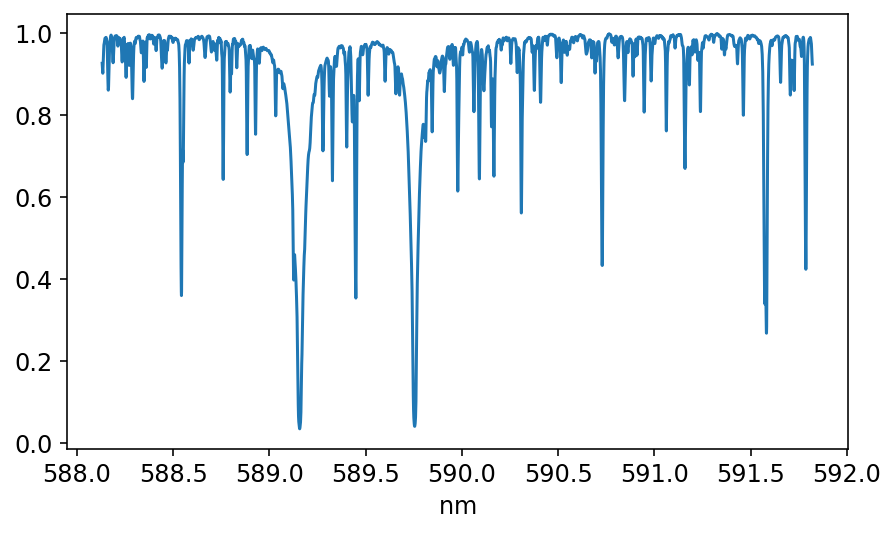

In [10]:
wnum, _, sp_obs, _ = numpy.loadtxt("int_nad.dat", unpack=True)
wnum = wnum / units.cm
wave = wnum.to("nm", equivalencies=units.spectral())

fig, ax = plt.subplots()
ax.plot(wave, sp_obs);

The Na I D$_1$ and D$_2$ are the two strongest lines. The line properties are listed in the table below.


|                  | Na I D$_1$ | Na I D$_2$ |
|------------------|-----------:|-----------:|
| Air wavelength (nm)  | 589.755         | 589.158  |
| Lower level      |  3s\,2S$_{1/2}$ | 3s\,2S$_{1/2}$ |
| Upper level      |  3p\,2P$^{\rm o}_{1/2}$ | 3p\,2P$^{\rm o}_{3/2}$ |
| $\chi_{1,l}$ (aJ)| 0     | 0      |
| $\chi_{1,u}$ (aJ)| 0.3368| 0.3371 |
|   $g_l$          | 2     | 2      |
|   $g_u$          | 2     | 4      |
| $f_{lu}$         | 0.318 | 0.631  |

They are resonance lines of sodium and therefore share the lower level. The Na ionisation energy of first ionisation ($\chi_\infty$) is 0.823 aJ, and subsequent ionisation energies are much higher (7.58 aJ and 11.48 aJ).

### 1.5 LTE Line Formation

We now have almost all the necessary ingredients to calculate the Na I D$_1$ line for the FALC model atmosphere. We compute the emergent intensity from the formal solution to the radiative transfer equation, equation (2).

The two unknowns in the integrand are the source function and the optical depth. Since we assume LTE, the source function is, for all processes, the Planck function: $S_\lambda^l = S_\lambda^c = S_\lambda^\mathrm{total} = B_\lambda(T)$. What remains is to evaluate both the continuum and line extinction as a function of height and wavelength. We need to calculate the intensity for the wavelengths of the Na I D$_1$ profile.

The monochromatic line extinction per m path length for a bound-bound transition between a lower level $l$  and an upper level $u$ is given by (in SI units):
\begin{equation}
\tag{8}
\label{eq:alpha}
\alpha_\lambda^l = \frac{e^2}{4\varepsilon_0 m_ec}\frac{\lambda^2}{c}\frac{n_l^\mathrm{LTE}}{N_E}N_H A_E f_{lu}\frac{H(a, u)}{\sqrt{\pi}\Delta\lambda_D}\left[1 - \mathrm{e}^{-hc/\lambda k_B T}\right]
\end{equation}

This is modified version of $\alpha_\nu$ from the lecture notes (Eq. (2.98) on page 31): the differences are that we explicitly write the broadening profile as the Voigt profile $V(a, \lambda)\equiv H(a, u)/(\sqrt{\pi}\Delta\lambda_D)$, a factor of $\lambda^2 / c$ from converting the frequency profile to wavelength profile, and writing the lower-level populations $n_l$ as a relative element population, hydrogen density, and element abundance ($A_E$). Finally, the constants in front are also different because we are using SI units.

We will now discuss how to calculate all the components of equation (\ref{eq:alpha}). Many of the terms are fundamental constants or are given in table above. For the element abundance $A_E$ for sodium use the value from [Asplund et al. (2009)](http://adsabs.harvard.edu/abs/2009ARA%26A..47..481A): $A_{Na}$ = 1.7378 $\cdot$ 10$^{-6}$. Two main terms remain: the level populations and the line profile.

#### 1.5.1 Level populations

The LTE population fraction $n_l^\mathrm{LTE}/N_\mathrm{E}$ (lower level
population scaled by the total element population) is given by the
combined Saha and Boltzmann distributions

\begin{eqnarray*}
   U_r 
   &\equiv& \sum_s g_{r,s} e^{-\chi_{r,s}/kT}
             \label{eq:parfunc} \\
   \frac{n_{r,s}}{N_r}
   &=& \frac{g_{r,s}}{U_r} e^{-\chi_{r,s}/kT}
             \label{eq:Boltzmann} \\
   \frac{N_{r+1}}{N_r}
   &=& \frac{1}{N_\mathrm{e}} \frac{2U_{r+1}}{U_r}
       \left(\frac{2 \pi m_\mathrm{e} kT}{h^2}\right)^{3/2} 
       e^{-\chi_r/kT},
            \label{eq:Saha}
\end{eqnarray*}

where $s$ is the level counter and $r$ the ionisation stage
counter. The level populations can be calculated in the same way as you've done for Project A. In the current directory you can find a model atom of Na I (plus a single state of Na II), called `NaI_atom.txt`. Have a look at the model atom file. It is very simple and has only the Na I D lines, plus the first state of Na II to calculate the partition function. The reason for this simplicity is to save on needless calculations, since you don't need information about the other levels to compute the Na I D lines.

#### 1.5.2 Line Profile and Broadening

The Voigt function  $H(a,u)$ describes the extinction profile shape and is defined by:

\begin{eqnarray*}
   H(a,u) &\equiv& \frac{a}{\pi} \int_{-\infty}^{+\infty}
            \frac{e^{-y^2}}{(u - y)^2 + a^2} \mathrm{d} y
                          \label{eq:Voigt} \\[1ex]
   y &=& \frac{v_\mathrm{los}}{c} \frac{\lambda_0}{\Delta \lambda_\mathrm{D}}\\
   u &=& \frac{\lambda-\lambda_0}{\Delta \lambda_\mathrm{D}}   
                          \label{eq:Voigtv} \\
   a &=& \frac{\lambda^2}{4\pi c}\frac{\gamma}{\Delta \lambda_\mathrm{D}},
                          \label{eq:Voigta} 
\end{eqnarray*}

where $v_\mathrm{los}$ is the velocity along the line of sight and $a$ the damping parameter. The Doppler width $\Delta \lambda_\mathrm{D}$ is not only set by the thermal broadening but in the 1D case it includes also the microturbulent "fudge parameter"  $v_\mathrm{turb}$ through defining it as:

\begin{equation*}
   \Delta \lambda_\mathrm{D} 
      \equiv \frac{\lambda_0}{c} \sqrt{\frac{2kT}{m} + v_\mathrm{turb}^2}
    \label{eq:microturbulence}
\end{equation*}
where $m$ is the mass of the line-causing particle in kilograms,
for sodium $m_\mathrm{Na} = 22.99 \times 1.6605 \times 10^{-27}$ kg. 

The damping parameter $a$ contains the different types of line broadening in $\gamma$. Van der Waals broadening dominates in most of the atmosphere, but in the higher layers natural broadening will also start being important. You will add both. For the natural broadening, we can use:

\begin{equation*}
   \gamma_\mathrm{rad} = A_{ul} = 
   6.67 \times 10^{13} \frac{g_l}{g_u} \, \frac{f_{lu}}{\lambda^2}
            \;\;\;\left[\mathrm{s}^{-1}\right],
      \label{eq:gamrad}
\end{equation*}
for $\lambda$ in nm.

For the van der Waals broadening you will use the recipe of [Anstee & O'Mara (1995)](https://ui.adsabs.harvard.edu/abs/1995MNRAS.276..859A). This is one of the most realistic recipes available to date, but is not available for all types of spectral lines (fortunately for us, it works for the Na I D lines). This recipe accounts for broadening from neutral hydrogen atoms:

\begin{equation*}
    \gamma_\mathrm{vdW} = 2\, a_0^2 \left(\frac{4}{\pi}\right)^{\alpha/2} \Gamma\left(\frac{4-\alpha}{2}\right)\bar{v}\,\sigma\, \left(\frac{\bar{v}}{10\;\mathrm{km/s}}\right)^{-\alpha}\; n_{\mathrm{HI}},
\end{equation*}


where $n_{\mathrm{HI}}$ is the number density of neutral hydrogen, $a_0$ is the Bohr radius (use `constants.a0`), $\Gamma$ is the Gamma function (use `scipy.special.gamma`), $\bar{v}$ is

\begin{equation*}
    \bar{v} = \left(\frac{8 k_B T}{\pi\mu_m} \right)^{1/2},
\end{equation*}

with $\mu_m$ the reduced mass of the two atoms, hydrogen and the line-producing element:

\begin{equation*}
    \mu_m = 1/\left(\frac{1}{m_\mathrm{H}} + \frac{1}{m_\mathrm{E}}\right).
\end{equation*}

Here, $m_\mathrm{E}=m_\mathrm{Na}$. The only remaining values are $\alpha$ and $\sigma$, which are tabulated in [Anstee & O'Mara (1995)](https://ui.adsabs.harvard.edu/abs/1995MNRAS.276..859A). For the Na I D lines, the values are:

| $\alpha$ | $\sigma$ |
|-----------|-----------|
| 0.237         | 409  |


Because $\gamma_\mathrm{rad}$ and $\gamma_\mathrm{vdW}$ are both associated with a Lorentzian profile, we can just sum them into $\gamma$ and replace that in the equation for the damping $a$:

\begin{equation*}
   \gamma = \gamma_\mathrm{rad} + \gamma_\mathrm{vdW}
\end{equation*}

You can use the same `voigt` function you used in Project A; it computes the profile $H(a,u)$.

#### 1.5.3 Line Profile in 3D

Computing line broadening in 3D is done in nearly the same way as in 1D, with the main difference being that the Doppler width does not need the added microturbulence, so we set $v_\mathrm{turb}$=0. The turbulent motions that $v_\mathrm{turb}$ was meant to emulate exist naturally in the 3D model. 

At each point in the 3D simulation the line profile has the usual Voigt profile shape $V(a, u)$ but it is shifted by $\Delta\lambda$, which is a function of $v_\mathrm{los}$ for each point in the grid, and each direction. But how do we enter this shift in the Voigt profile?

The way the Voigt function is built, it is a function of the damping parameter $a$ and the dimensionless wavelength $u$:

$$
u \equiv \frac{\Delta\lambda_i}{\Delta\lambda_D}.
$$

Numerically, $\Delta\lambda_i$ is typically an array of wavelength shifts around the line centre $\lambda_0$, e.g. $\Delta\lambda_i = -0.2, -0.1, 0, 0.1, 0.2$ nm. This is a way to measure the wavelength spacing in units of thermal broadening. So for $u=$ 1 we are one Doppler broadening away from the line core, $u=$ 5, five Doppler broadenings and so on. By definition, the peak of the Voigt function will be at $u=$ 0. However, when there is a Doppler shift $\Delta\lambda_\mathrm{los}$ caused by a line-of-sight velocity:

$$
\Delta\lambda_\mathrm{los} = \lambda_0\frac{v_\mathrm{los}}{c},
$$

the peak of the Voigt function should be at $u=-\Delta\lambda_\mathrm{los} / \Delta\lambda_D$. In this definition, a positive $v_\mathrm{los}$ corresponds to an upflow (movement towards the observer), meaning that the wavelength shift is negative (blueshift). The way to add this shift $\Delta\lambda_\mathrm{los}$ is *not* in the Doppler width, but in $u$, and at every grid point of the simulation, because the line of sight will be different at every grid point. In the 3D case, the calculation of the normalised velocity $u$ (for the Voigt function) should therefore be:

$$
u = \frac{\left(\Delta\lambda_i + \Delta\lambda_\mathrm{los} \right)}{\Delta\lambda_D}.
$$

When $\mu=1$, $v_\mathrm{los} = v_z$. For $\mu\neq 1$, you will need to project the velocities, so that

$$
v_\mathrm{los} = v_z \cos\theta + v_y \sin\theta \sin\varphi + v_x \sin\theta \cos\varphi,
$$

where $\theta$ is the polar angle ($\mu=\cos\theta$) and $\varphi$ the azimuthal angle.

---

### Exercise 1: Model atmospheres and continuum extinction [20 points]


<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* *[6 points]* Using the FALC atmosphere, plot the ionisation fraction of hydrogen and temperature vs height side by side (use a log plot, and clip the temperature at 10,000 K). Why does the ionisation fraction plot resemble the temperature? And why is its shape a bit different (appears "tilted") from the temperature plot?

* *[7 points]* Plot the extinction coefficient $\alpha_\lambda^c$ using only H$^-$ extinction (bound-free and free-free, use `compute_hminus_extinction`) as function of wavelength, for wavelengths between 300-4000 nm, and for the temperature and density at the solar surface (height = 0) in the FALC model. Now, on a separate figure plot the observed solar continuum intensity in brightness temperature units:
    1. Read the intensity from the file `solspect.dat` (first column is wavelength in μm, and the last column is $I_\lambda^c$ in units of $10^{10}$ erg s$^{-1}$ cm$^{-2}$ μm$^{-1}$ sr$^{-1}$). 
    2. Invert the Planck function analytically to obtain an equation that converts from intensity $I_\lambda$ into brightness temperature $T_b$ (defined by $B_\lambda(T_b) \equiv I_\lambda$).
    3. Convert $I_\lambda^c$ to brightness temperature, and plot it against wavelength. 
    4. Discuss the shape of this curve, and how it is related to the H$^-$ extinction plot. The curve peaks near $\lambda$ = 1.6 μm. What does that mean for the radiation escape at this wavelength?


* *[7 points]* Compute $\alpha_\lambda^c$ from H$^-$ as a function of height for the FALC model, at $\lambda$ = 0.5 μm. Do the same for $\alpha^T$, the Thomson scattering off free electrons, which can be obtained by the wavelength-independent Thomson cross section:  
\begin{equation*}
        \sigma^{\rm T} = 6.652 \times 10^{-29} \rm{m}^2.
\end{equation*} 
Plot $\alpha^c$ from H$^-$, $\alpha^T$ and the total $\alpha_\lambda^c=\alpha_\lambda^{H-} + \alpha^T$ at 0.5 μm as a function of height for the FALC model. Discuss.
    
</div>


### Exercise 2: Continuum height of formation and contribution function [35 points]

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* *[6 points]* Using $\alpha^c$ you computed previously (from H$^-$ and Thomson scattering) from the FALC model, use equation (4) to compute $<\!h\!>$, the  mean height of formation at 500 nm, and use equation (3) to compute the contribution function also at 500 nm. Plot the contribution function (normalise by maximum) vs. height, and overplot $<\!h\!>$ as a vertical line. Discuss the plot and the meaning of $<\!h\!>$. To complement the discussion, plot on a separate figure the same contribution function but vs the optical depth at 500 nm (use log scale in x axis), and overplot $\tau_{500}$=1 as a vertical line. Discuss the relation between the two plots.
    
* *[7 points]* Compare the contribution functions from the FALC model (use same $\alpha^c$) at $\lambda$ = 0.5, 1, 1.6, 5 μm (all in one plot) and discuss what causes the changes with wavelength.

* *[10 points]* With 3D atmospheres, there is no single height of formation, since radiation will behave differently for each 1D column. One can compute $<\!h\!>$ and the contribution function per column, but a related (and faster to compute) quantity is the height where the optical depth reaches unity, $h(\tau_\lambda=1)$. Compute $\tau_{500}$ for each vertical column in the 3D model, and compute $h(\tau_{500}=1)$ by interpolating, for each column, the curve of $\tau_{500}$ vs height. Your $h(\tau_{500}=1)$ should be a 2D array. Plot a histogram of its values, and then the array itself as a 3D surface plot (see below for hints on how to make this plot). Discuss the variations of $h(\tau_{500}=1)$.

* *[12 points]* Compute the continuous intensity at 500 nm from the 3D atmosphere (top of the box) at three viewing angles: $\mu$=1 (vertical), 0.4 and 0.2. Rotate only by the polar angle, do not perform an azimuthal rotation. Plot the intensity maps with identical physical sizes in the x and y axes.
    
</div>

To make the 3D surface plot of $h(\tau_{500}=1)$, the following code is recommended. Note that you must import `Axes3D` *before* creating the figure:

```python
from mpl_toolkits.mplot3d import Axes3D

# x and y grids, from 0 to 6 Mm (box size), 256 points
X, Y = numpy.mgrid[0:6:256j, 0:6:256j]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# tau1_height must be a 2D array (256, 256) with the
# heights where tau = 1 in km
ax.plot_surface(X, Y, tau1_height, cmap='magma', rcount=100, ccount=100)
ax.axis((6.3, -0.3, -0.3, 6.3));
ax.set_xlabel("y (Mm)")
ax.set_ylabel("x (Mm)")
ax.set_zlabel("z (km)")
```

This should give a plot similar to the following:

<img src="https://tiagopereira.space/ast4310/images/tau1_3d.png" width=500px>

If using the `inline` backend, your 3D plot will just be a static image. But if you use an interactive backend (e.g. `%matplotlib widget`) you will be able to rotate and interact with the plot.


### Exercise 3: Computing the Na I D line profile [40 points]

You now have all the ingredients to compute the Na I D$_1$ line profile from a model solar atmosphere. Such calculation, also known as the predicted spectrum or synthetic spectrum, will give the line profile you would expect to observe if the model was a real star. It can then be used to compare with actual observations, where a good match would suggest the model reproduces the mean atmospheric stratification of the star. An accurate calculation of a line profile thus depends critically on knowning many details: from a good model of the star's atmosphere, accurate knowledge about atomic physics and properties of the transition, and detailed radiative transfer calculations. In this exercise, you will see if all of those ingredients are up to the task: compute the Na I D$_1$ line profile and compare with observations.


<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* *[15 points]* Compute the Na I D$_1$ intensity at $\mu$=1 and 0.2 from the FALC model. Calculate the profile for about 200 wavelength points, centred at the line core, and extending 0.1 nm on either side. Plot the $\mu$=1 normalised line profile against the observations from `int_nad.dat` and discuss the differences. Explain why your computed profile has a line-centre reversal and the observations do not. Discuss the differences between the $\mu$=1 and 0.2 profiles (plot them in an absolute scale, not normalised), and explain the centre-to-limb variation at the line core and wings.
    
* *[10 points]* Now calculate the $\mu$=1 intensity for the 3D model, taking into account the Doppler shifts at each column. Compute the spatially-averaged line profile, and plot it against a selection of line profiles from different xy points of the simulation (e.g. every 10th point in the y and x directions), so you can see the spatial variations between line profiles).
    

* *[15 points]* After you compute the intensities in the point above, you should obtain an array whose shape is `(nwave, nx, ny)`. Plot a spectrogram along one row or column of the simulation (e.g. `intensity_3d[:, 0]`), where the x axis is wavelength and the y axis is physical distance in Mm. You should see the meandering shifts of the line core, caused by Doppler motions. Exploring spectrograms from different slices, try to find a simulation column for which the line core peak is stronger (or comparable) than the intensity in the far wings. Compare with a different location where the wings are much stronger than the line core. Plot the two spectra and, based on your radiative transfer knowledge, explain the reason why they look so different. (Hint: look at the two source functions.)
</div>